In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

from keras import Sequential
from keras.layers import (
    Dense,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    Flatten,
    Dropout,
    LeakyReLU,
    InputLayer,
    Reshape,
)

In [3]:
def discriminator():
    depth = 64
    model = Sequential(
        [
            InputLayer((100, 100, 3)),
            # Conv 1
            Conv2D(depth * 1, (3, 3), strides=(2, 2), padding="same"),
            LeakyReLU(0.2),
            Dropout(0.25),
            # Conv 2
            Conv2D(depth * 2, (3, 3), strides=(2, 2), padding="same"),
            LeakyReLU(0.2),
            Dropout(0.25),
            # Conv 3
            Conv2D(depth * 4, (3, 3), strides=(2, 2), padding="same"),
            LeakyReLU(0.2),
            Dropout(0.25),
            # Connected
            Flatten(),
            Dense(1, activation="sigmoid"),  # output - T or F
        ]
    )
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


discriminator().summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 50, 50, 64)        0         
                                                                 
 dropout (Dropout)           (None, 50, 50, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 25, 25, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 25, 25, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 256)       2

In [4]:
def generator(latent_dim):
  model = Sequential([
    # 25 x 25 base image
    Dense(25*25*128, input_dim=latent_dim),
    LeakyReLU(0.2),
    Reshape((25, 25, 128)),
    # upsample to 50 x 50
    Conv2DTranspose(128, (4, 4), strides=(2,2), padding='same'),
    LeakyReLU(0.2),
    # up sample to 100 x 100
    Conv2DTranspose(128, (4, 4), strides=(2,2), padding='same'),
    LeakyReLU(0.2),
    Conv2D(3, (25, 25), activation='sigmoid', padding='same'),
  ])
  return model

generator(100).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 80000)             8080000   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 80000)             0         
                                                                 
 reshape (Reshape)           (None, 25, 25, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 50, 50, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 50, 50, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 100, 100, 128)    262272    
 ranspose)                                            

In [5]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

(25, 100, 100, 3)


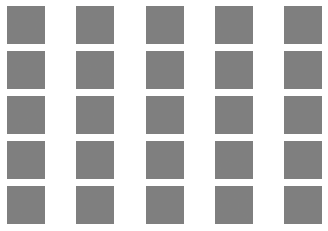

In [6]:
latent_dim = 100
n_samples = 25
gen = generator(latent_dim)
X, _ = generate_fake_samples(gen, latent_dim, n_samples)

# This uses completely random noise instead of fake samples
# X = np.random.random(size=(25,100,100,3))

print(X.shape)
for i in range(n_samples):
  rgb = X[i, :, :]
  r, g, b = rgb.T[:, :]
  img = cv2.merge([r, g, b])
  plt.subplot(5, 5, i+1)
  plt.axis('off')
  plt.imshow(img)

In [7]:
def gan(g_model, d_model):
  d_model.trainable = False
  model = Sequential([
    g_model,
    d_model,
  ])
  model.compile(loss='binary_crossentropy', optimizer='adam')
  return model

gan(generator(100), discriminator()).summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 100, 100, 3)       8844547   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 414081    
                                                                 
Total params: 9,258,628
Trainable params: 8,844,547
Non-trainable params: 414,081
_________________________________________________________________


In [8]:
def train_gan(gan_model: Sequential, latent_dim, epochs=100, batch_size=64):
  for i in range(epochs):
    x_gan = generate_latent_points(latent_dim, batch_size)
    y_gan = np.ones((batch_size, 1))
    gan_model.train_on_batch(x_gan, y_gan)

In [9]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	print("bat_per_epo", bat_per_epo)
	print("half_batch", half_batch)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = np.ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

In [10]:
# load dataset
path = '../Data/Processed_Data/Drake_Hotline_Bling/imgs/'
raw_images = []
for i in range(100):
  img = cv2.imread(path + f'{i}.png')
  raw_images.append(img)
  
dataset = np.array(raw_images)
print(dataset.shape)


(100, 100, 100, 3)


In [21]:
latent_dim = 100
g_model = generator(latent_dim)
d_model = discriminator()
gan_model = gan(g_model, d_model)
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=20)

bat_per_epo 5
half_batch 10
>1, 1/5, d=0.937, g=0.303
>1, 2/5, d=0.698, g=0.221
>1, 3/5, d=0.983, g=0.260
>1, 4/5, d=0.917, g=0.712


KeyboardInterrupt: 

(25, 100, 100, 3)


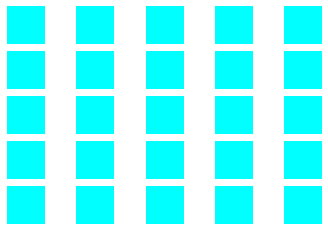

In [20]:
X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
print(X.shape)
for i in range(n_samples):
  plt.subplot(5, 5, i+1)
  plt.axis('off')
  # rgb = X[i, :, :]
  # r, g, b = rgb.T[:, :]
  # img = cv2.merge([r, g, b])
  # plt.imshow(img)
  plt.imshow(X[i, :, :, :])
  